# Neural Cellular Automata 
What we are going to do is to try to create a diffrentiable self-organising system Neural Cellular Automata with just a few hundred parameters.We set up a system of 'cells', often represented by pixels in a line or a grid. Each cell can 'see' their immediate neighbors, and can change it's output based on this information. We ll use Cellular Automata models to identifying cell-level rules which give rise to complex, regenerative behavior of the collective. 

Cellular Automatas consist of a grid of cells being iteratively updated, with the same set of rules being applied to each cell at every step.The new state of a cell depends only on the states of the few cells in its immediate neighborhood.

So to put it in simple words, we start out with a random grid with pure noise pixels. Each cell in the grid only knows about the states of its immediate neighbourhood cells.With this structure in place, we will produce a predefined multicellular pattern on a 2D grid all by using differentiable update rules without any global update clock.

<!-- [blue_text](https://arxiv.org/pdf/2105.07299.pdf) -->


We ll be writing our training loops,callbacks and hooks using MiniAi. MiniAI is a small and flexible library which goes under the hood, and gives us the flexibility to customize every part of model training - from the model initialization to writing hooks to look inside our model.
Let's go ahead and install MiniAi.


In [1]:
!pip install -Uqq git+https://github.com/fastai/course22p2

In [ ]:
pip install git+https://github.com/huggingface/transformers

## Importing Libraries 

In [3]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL, einops
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from IPython.display import display, clear_output, HTML
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr
from PIL import Image
import base64

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

#### We will use our NCA to identify the pattern of the following style image and reproduce this pattern from random noise.

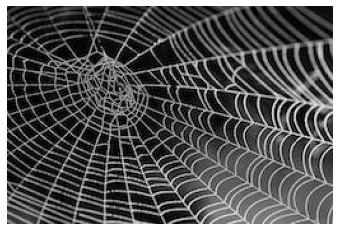

In [4]:
def download_image(url):
    imgb = fc.urlread(url, decode=False) 
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.
url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"
# url = "https://as2.ftcdn.net/v2/jpg/04/67/20/91/1000_F_467209130_vMox1GNkLxsrL4S9v3tWGoMOeNoGSJT2.jpg"
# url = "https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/dotted/dotted_0201.jpg"
# url = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/bubbly/bubbly_0101.jpg'
# url = "https://www.freevector.com/uploads/vector/preview/17677/FreeVector-Leaf-Pattern.jpg"

style_im = download_image(url).to(def_device)
show_image(style_im);

### Style Loss
We will use Vgg16 to extract features from the style image. The resultant feature maps contain low level feature representations of the style image encoded sptially. But we don't want that. We need encoded information of patterns, for that we need to figure out what is the co-relation between these low-level features.
Think about it like this, just having individual feature maps would give you the representation of each feature (a curve, dots, edges etc), but the degree of corelation between these features encoded in a matrix would be able to identify the patterns that appear in the image.
We will use **Gram Matrices** to compute these - for a feature map with **f** features in an **h x w** grid, we'll flatten out the spatial component and then for every feature we'll take the dot product of that row with itself, giving an **f x f** matrix as the result.

Our loss function will be the L2 Loss between the Gram matrix of Style image, and the iteratively updated Gram matrix of the input random noise grid as keep going through the forward and backward passes of our NCA model.   

The picture below eloquently captures what a Gram Matrix is


<!-- ![alternatvie text](images.png) -->

<img src="images.png" alt="Alternative text"/>
                                                                            

In [5]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def calc_features(imgs, target_layers=[18, 25]): 
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

def calc_grams(img, target_layers=[1, 6, 11, 18, 25]):
    return L(torch.einsum('bchw, bdhw -> cd', x, x) / (x.shape[-2]*x.shape[-1])
            for x in calc_features(img, target_layers))

class StyleLossToTarget():
    def __init__(self, target_im, target_layers=[1, 6, 11, 18, 25]):
        fc.store_attr()
        with torch.no_grad(): self.target_grams = calc_grams(target_im[None], target_layers)
    def __call__(self, input_im): 
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_grams(input_im, self.target_layers), self.target_grams))

style_loss = StyleLossToTarget(style_im)
style_loss(torch.rand(1, 3, 256, 256).to(def_device))

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

tensor(1179.7140, device='cuda:0', grad_fn=<AddBackward0>)

In [23]:
vgg16

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

Let's set up our NCA Model now

In [6]:
num_channels = 4
hidden_n = 8

We will have intial grids with the image size which we want and values of each cell will be 0.
We make one grid with grid size of 128 and channels as defined above 

In [7]:
def make_grids(n, sz=128): return torch.zeros(n, num_channels, sz, sz).to(def_device)
x = make_grids(1)
x.shape

torch.Size([1, 4, 128, 128])

Now we will have our pre defined filters which we will aplly across our grids. These are four 3x3 filters which we will apply acorss each of the 4 channels individually

In [8]:
# Hard-coded filters
filters = torch.stack([
    tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),
    tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),
    tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T,
    tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])
]).to(def_device)
filters.shape

torch.Size([4, 3, 3])

In [9]:
def perchannel_conv(x, filters):
    '''filters: [filter_n, h, w]'''
    b, ch, h, w = x.shape
    y = x.reshape(b*ch, 1, h, w)
    y = F.pad(y, [1, 1, 1, 1], 'circular') # << Note pad mode
    y = F.conv2d(y, filters[:,None])
    return y.reshape(b, -1, h, w)

We apply these filters across every four channels of our input zero grids, to have the final 16 channels 

In [10]:
model_inputs = perchannel_conv(x, filters)
model_inputs.shape

torch.Size([1, 16, 128, 128])

In [11]:
filters.shape[0]

4

## NCA Model
We can now go ahead and define our NCA model class

Few things to note in the NCA class we have written
- We zero out the weights of the second layer while initializing - By initializing the weights to zero, you provide a starting point that might encourage the model to learn meaningful features from the data.
- Random update: only update ~50% of the cells. This is just like applying Dropout
     - This Random update is inspired by biology where in a biological system not all updates are done with respect to any global clock at the same instance while it grows or updates. Similarily we add randomess to all the updates in our model   


In [12]:
class SimpleCA(nn.Module):
    def __init__(self, zero_w2=True):
        super().__init__()
        self.w1 = nn.Conv2d(num_channels*4, hidden_n, 1)
        self.relu = nn.ReLU()
        self.w2 = nn.Conv2d(hidden_n, num_channels, 1, bias=False)
        if zero_w2: self.w2.weight.data.zero_()


    def forward(self, x, update_rate=0.5):
        y = perchannel_conv(x, filters) # Apply the filters
        y = self.w2(self.relu(self.w1(y))) # pass the result through our simple neural network
        b, c, h, w = y.shape
        update_mask = (torch.rand(b, 1, h, w).to(x.device)+update_rate).floor() # Random update
        return x+y*update_mask

    def to_rgb(self, x):
        return x[...,:3,:,:]+0.5

## Let's get Training
We will be using MiniAi framework and its customised methods(classes,callbacks etc) to write our training loop 

In [13]:
class LengthDataset():
    def __init__(self, length=1): self.length=length
    def __len__(self): return self.length
    def __getitem__(self, idx): return 0,0

def get_dummy_dls(length=100):
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1),
                       DataLoader(LengthDataset(1), batch_size=1))

We following is a callback that plots graphs and training metrics using MiniAi

In [14]:
class NCAProgressCB(ProgressCB):
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if not (hasattr(learn, 'metrics') and learn.training): return 
        self.losses.append(learn.loss.item())
        mbar = self.mbar
        if not hasattr(mbar, 'graph_fig'):
            mbar.graph_fig, mbar.graph_axs = plt.subplots(1, 2, figsize=(12, 3.5))
            mbar.graph_out = display(mbar.graph_fig, display_id=True)

        # Update preview image every 64 iters
        if (len(self.losses))%64 != 10: return 
        
        # Plot losses:
        mbar.graph_axs[0].clear()
        mbar.graph_axs[0].plot(self.losses, '.', alpha=0.3)
        mbar.graph_axs[0].set_yscale('log')
        mbar.graph_axs[0].set_ylim(tensor(self.losses).min(), self.losses[0])
        
        # Show preview images:
        rgb = learn.model.to_rgb(learn.preds.detach()).clip(0, 1)
        show_image(torchvision.utils.make_grid(rgb), ax=mbar.graph_axs[1])
        
        # Update graph
        mbar.graph_out.update(mbar.graph_fig)

Along with Style Loss which we defined above, we also use overflow loss which penalises predictions that overflow beyond a range (-1 to 1 in our case)

In [15]:
class NCACB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, ca, style_img_tensor, style_loss_scale=0.1, size=256, 
                 step_n_min=32, step_n_max=96, batch_size=4):
        fc.store_attr()
        with torch.no_grad(): self.pool = make_grids(256, sz=size) # Set up a 'pool' of grids
    
    def predict(self, learn): 
        
        # Pick some random samples from the pool
        #we select random 4 numbers to be the current batch and use those grid from the pool
        batch_idx = torch.randint(0, len(self.pool), (self.batch_size,))
        x = self.pool[batch_idx]
        
        # occasionally zero out some samples
        #if a random number is less than 1 from selecting 1 to 7, it zeros out 
        if torch.randint(8, (1,)) < 1: 
            x[:1] =  make_grids(1, sz=self.size)
        
        # Apply the model a number of times
        for _ in range(torch.randint(self.step_n_min, self.step_n_max, (1,))):
            x = learn.model(x)
        
        # Update pool
        with torch.no_grad(): self.pool[batch_idx] = x
        
        # and store preds
        learn.preds = x
        
    def get_loss(self, learn): 
        style_loss = learn.loss_func(learn.model.to_rgb(self.learn.preds))
        overflow_loss = (learn.preds-learn.preds.clamp(-1.0, 1.0)).abs().sum()
        learn.loss = overflow_loss + style_loss*self.style_loss_scale
        
    def backward(self, learn):
        learn.loss.backward()
        # Gradient normalization:
        for p in learn.model.parameters():
            p.grad /= (p.grad.norm()+1e-8) 
        
    def before_fit(self, learn): self.learn=learn 

In [16]:
model = SimpleCA().to(def_device)
cbs = [NCACB(model, style_im), NCAProgressCB(), MetricsCB()]
style_loss = StyleLossToTarget(style_im)

learn = Learner(model, get_dummy_dls(1200), style_loss, lr=1e-3, cbs=cbs, opt_func=torch.optim.Adam)

loss,epoch,train
164.076,0,train
26.250,0,eval


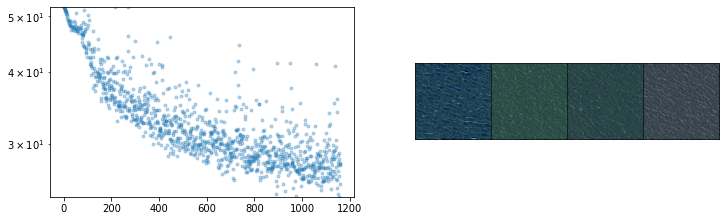

In [17]:
learn.fit(1)

## Results

Below is the final batch of images in training

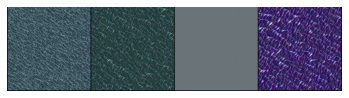

In [24]:
# Check out the final batch:
rgb = model.to_rgb(learn.preds.detach())
rgb = torchvision.utils.make_grid(rgb)
show_image(rgb.clip(0, 1));

Let's put our trained NCA model to use. We start of with a random noise grid as usual, and apply the model to this grid for n number of times(900 below). With a few hundred steps we see the patterns forming from our style image. If we look closely we can see how eloquently these patterns are forming, with even spacing and ending properly around edges. All this with a model with just a few hundred paramerers. Having the ability to capture regenerative, complex patterns with just few hundred parameters is the real beauty of these NCA self organising models.

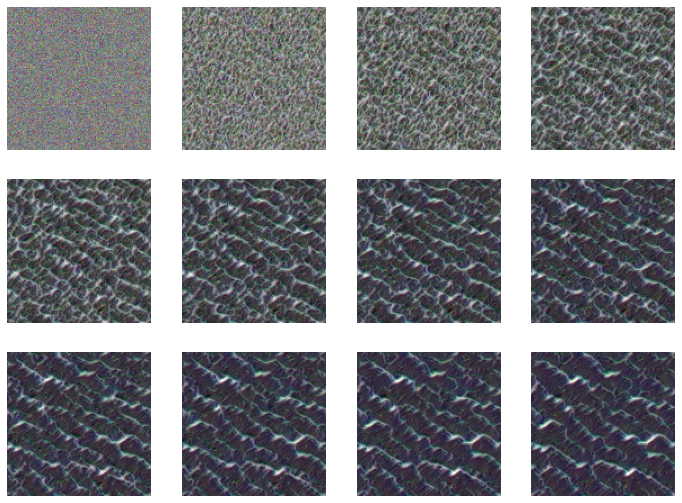

In [26]:
# Apply a numbe of times to a random initial starting grid:
images = []
x = torch.randn(1, num_channels, 128, 128).to(def_device) * 0.1
with torch.no_grad():
    for i in range(1200):
        x = model(x)
        if i%100==0: images.append(model.to_rgb(x)[0].clip(0, 1))
show_images(images)

So just with 168 weight parameters, we have a model which can create patterns of the style image from random noise 

In [30]:
sum(p.numel() for p in model.parameters()) # !!

168

## Video
Let's put our images we get from our model at different timesteps, into a video to see the progress of how the patterns develop over time as the grid goes from noise to changing some pixels to finally developing mature patterns present in the Style Image.

In [28]:
def progress_video():
  # Turn the images in steps/ into a video with ffmpeg
  !ffmpeg -y -v 0 -framerate 24 -i steps/%05d.jpeg video.mp4

  # Display it inline
  mp4 = open('video.mp4','rb').read()
  data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
  return HTML("""
  <video width=256 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

In [29]:
!mkdir -p steps
!rm steps/*
x = torch.randn(1, num_channels, 128, 128).to(def_device) * 0.1
for i in range(900):
  with torch.no_grad():
    x = model(x)
    img = model.to_rgb(x).detach().cpu().clip(0, 1).squeeze().permute(1, 2, 0)
    img = Image.fromarray(np.array(img*255).astype(np.uint8))
    img.save(f'steps/{i:05}.jpeg')
progress_video()

## Conclusion

In the post today, we tried out the vanilla NCA model. We saw the power of self organising systems.We made pretty pictures using differentiable self-organizing systems. There is a lot of scope to make this model detect and regenerate complex persisting patterns.
We only saw a small glimpse of self organising systems.
We can add more kernels, make the model deeper, try out different loss function among other improvements to see how complex patterns these models can capture, and regenerate.
We can erase out part of the pattern from the image and still the model will be able to regenerate the pattern with just the knowledge of the neighbouring cells. We will try this and much more in the upcoming posts. 
